# Content

- **Introduction to Business Case: DL Engineer at BBC**
- **Dataset EDA**
  - Attribute information
  - Category distribution plot
- **Traditional methods : Why they won't work**
  - MLP Classifiers : No temporal components
- **Introduction to RNNs**
  - Advantages
  - RNNs unravelled over time
  - Types of RNNs
- **RNN Architecture**
  - Parameters
  - Inputs
  - Weight matrices
- **Training a Many to One RNN model**
  - Forward propagation
  - Backpropagation through time
  - Gradient clipping
- **Expanding training methods to other types of RNNS**
  - Multi-output RNNs
  - Bidirectional RNNs
  
- **Code Implementation**
  - Text preprocessing
    - Text cleaning 
    - Fixing a sequence length
    - splitting the dataset
  - Text processing
    - OHE labels
    - Tokenization & padding
  - Training an RNN
    - Defining RNN architecture
    - Model training
    - Making predictions
    - Confusion matrix

- **Conclusion**

# RESEARCH PAPERS
1. [A Critical Review of Recurrent Neural Networks
for Sequence Learning](https://arxiv.org/pdf/1506.00019.pdf)
2. [Fundamentals of Recurrent Neural Network (RNN)
and Long Short-Term Memory (LSTM) Network](https://arxiv.org/pdf/1808.03314.pdf)

# How to classify a news headline into a relevant category?

`You are an DL Engineer at BBC.`

**`Problem Statement`:** BBC wants to auto categorize the news into various categories which will also help in recommending the right news articles to it users at a later stage.


`Note:` *BBC - British Broadcasting Corporation*

### Dataset

A sample of 2225 news article and their relavant category.

**Attribute information:**
- filename - name of the file for that news.
- title - the headline of the news
- content - main news content.
- **category** - target variable that describes the type of a news item.


In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import re
import matplotlib.pyplot as plt

In [2]:
!gdown 1POmzYEQZgZVqJO3F_cyNcd4QmoNE_mCv

Downloading...
From: https://drive.google.com/uc?id=1POmzYEQZgZVqJO3F_cyNcd4QmoNE_mCv
To: /content/bbc-news-data.csv
100% 5.08M/5.08M [00:00<00:00, 22.2MB/s]


---
# Reading the dataset
---

In [3]:
df = pd.read_csv("/content/bbc-news-data.csv", sep="\t")
df

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [4]:
# Dropping the empty sub-title
print(df.shape)
df = df[((~df.title.isnull()) & (~df.content.isnull()))].reset_index(drop=True)
print(df.shape)

df

(2225, 4)
(2225, 4)


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


Text(0, 0.5, 'Count')

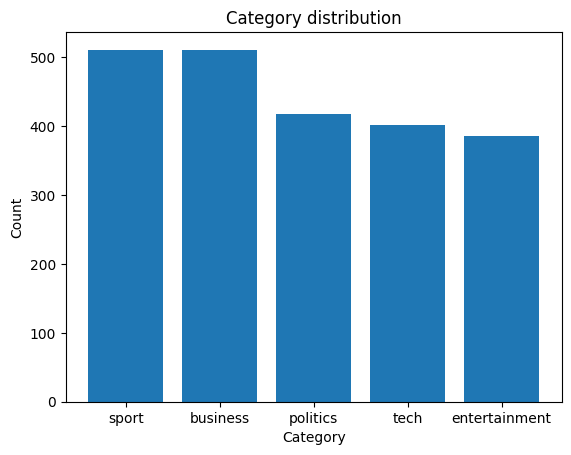

In [5]:
plt.bar(df.category.value_counts().index, df.category.value_counts().values)
plt.title('Category distribution')
plt.xlabel("Category")
plt.ylabel("Count")

Let's take a look at one of the sample example of how the data looks like

In [6]:
ind=1807
print(f'Title: {df.title[ind]}')
print(f'Category: {df.category[ind]}')

Title: Federer joins all-time greats
Category: sport


---
# Code Implementation
---

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import string

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Text cleaning

In [8]:
def data_cleaning(text):
    
    # Lower the words in the sentence
    cleaned = text.lower()
    
    # Replace the full stop with a full stop and space
    cleaned = cleaned.replace(".", ". ")

    # Remove the stop words : optional pre-processing step
    tokens = [word for word in cleaned.split() if not word in stop_words]
    
    # Remove the punctuations
    tokens = [tok.translate(str.maketrans(' ', ' ', string.punctuation)) for tok in tokens]
    
    # Joining the tokens back to form the sentence
    cleaned = " ".join(tokens)
    
    # Remove any extra spaces
    cleaned = cleaned.strip()
    
    return cleaned


In [9]:
for index, data in tqdm(df.iterrows(), total=df.shape[0]):
    df.loc[index, 'title'] = data_cleaning(data['title'])


100%|██████████| 2225/2225 [00:00<00:00, 2737.30it/s]


# Fixing the sequence length

<Axes: >

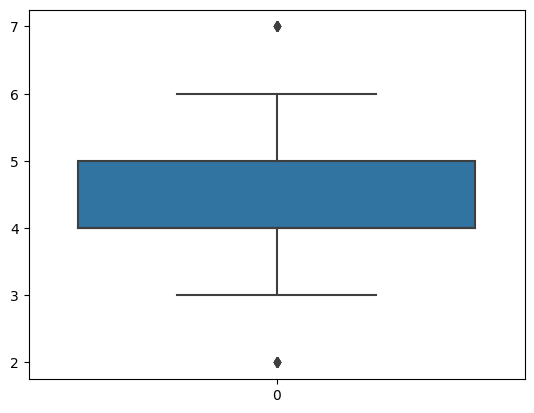

In [10]:
sns.boxplot(df['title'].str.split(" ").str.len())

As we can see that maximum number of words in the title is 7, we can set the sequence length to be the max words in the longest sentence.

In [11]:
max_sentence_len = df['title'].str.split(" ").str.len().max()
total_classes = df.category.nunique()

print(f"Maximum sequence length: {max_sentence_len}")
print(f"Total classes: {total_classes}")

Maximum sequence length: 7
Total classes: 5


# Splitting the data to train and test

In [12]:
np.random.seed(100)
train_X, test_X, train_Y, test_Y = train_test_split(df['title'], 
                                                    df['category'], 
                                                    test_size=0.2, 
                                                    random_state=100)
train_X = train_X.reset_index(drop=True)
test_X = test_X.reset_index(drop=True)
train_Y = train_Y.reset_index(drop=True)
train_Y = train_Y.reset_index(drop=True)

In [13]:
train_X.head()

0        moya fights back indian title
1    radcliffe enjoys winning comeback
2         edwards tips idowu euro gold
3         podcasts mark rise diy radio
4     bnp leader nick griffin arrested
Name: title, dtype: object

In [14]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((1780,), (1780,), (445,), (445,))

# One hot Encode the labels

In [15]:
train_Y = pd.get_dummies(train_Y).values
test_Y = pd.get_dummies(test_Y).values

In [16]:
validation = test_Y.argmax(axis=1)

# Tokenize the input text and pad them

In [30]:
def tokenize_and_pad(inp_text, max_len, tok):

    text_seq = tok.texts_to_sequences(inp_text)
    text_seq = pad_sequences(text_seq, maxlen=max_len, padding='post')
    
    return text_seq

text_tok = Tokenizer()
text_tok.fit_on_texts(train_X)
train_text_X = tokenize_and_pad(inp_text=train_X, max_len=max_sentence_len, tok=text_tok)
test_text_X = tokenize_and_pad(inp_text=test_X, max_len=max_sentence_len, tok=text_tok)
vocab_size = len(text_tok.word_index)+1

print("Overall text vocab size", vocab_size)

Overall text vocab size 3360


In [29]:
train_text_X

array([[   0,    0,  275, ...,   43,  164,  165],
       [   0,    0,    0, ..., 1382,  502,  166],
       [   0,    0, 1383, ..., 1384,   58,  366],
       ...,
       [   0,    0,    0, ...,  444,   72,    9],
       [   0,    0,    0, ..., 1179,  487, 1180],
       [   0,    0,    0, ..., 1274, 1275,  322]], dtype=int32)

In [18]:
train_X.head()

0        moya fights back indian title
1    radcliffe enjoys winning comeback
2         edwards tips idowu euro gold
3         podcasts mark rise diy radio
4     bnp leader nick griffin arrested
Name: title, dtype: object

In [19]:
train_text_X

array([[ 275,  772,   43, ...,  165,    0,    0],
       [ 501, 1382,  502, ...,    0,    0,    0],
       [1383,  773, 1384, ...,  366,    0,    0],
       ...,
       [ 645,  444,   72, ...,    0,    0,    0],
       [  68, 1179,  487, ...,    0,    0,    0],
       [1273, 1274, 1275, ...,    0,    0,    0]], dtype=int32)

# Choose the latent dimension and embedding dimension

<b>Latent dimension</b>: Dimension of the weight matrix U, V, W
<br>
<b>Embedding dimension</b>: Dimension of the word embeddings at the embedding layer

In [20]:
latent_dim=50
embedding_dim=100

# Define the RNN model architecture 

* The embedding layer with 100 dimension
* A single Vanilla RNN unit with 50 dimensions
* A final output layer with 5 units(5 classes) with the softmax activation function

In [33]:
seed=56
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, trainable=True))
model.add(SimpleRNN(latent_dim, recurrent_dropout=0.2, return_sequences=False, activation='tanh'))

model.add(Dense(total_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         336000    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 343,805
Trainable params: 343,805
Non-trainable params: 0
_________________________________________________________________


# Model training

* Optimizer: Adam
* Loss: Categorical cross-entrophy since it is a multiclass classification probem
* Early stopping: Used to stop training if validation accuracy does not improve while training to avoid overfitting

In [22]:
tf.random.set_seed(seed)
np.random.seed(seed)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', 
                               mode='max', 
                               verbose=1, 
                               patience=5)

model.fit(x=train_text_X, y=train_Y, 
          validation_data=(test_text_X, test_Y),
          batch_size=64, 
          epochs=10, 
          callbacks=[early_stopping])

Epoch 1/10
28/28 [==============================] - 6s 42ms/step - loss: 1.5865 - acc: 0.2742 - val_loss: 1.5531 - val_acc: 0.2674
Epoch 2/10
28/28 [==============================] - 1s 22ms/step - loss: 1.3310 - acc: 0.5427 - val_loss: 1.2787 - val_acc: 0.4989
Epoch 3/10
28/28 [==============================] - 1s 24ms/step - loss: 0.6941 - acc: 0.8197 - val_loss: 0.8098 - val_acc: 0.7146
Epoch 4/10
28/28 [==============================] - 1s 21ms/step - loss: 0.2443 - acc: 0.9500 - val_loss: 0.8471 - val_acc: 0.7438
Epoch 5/10
28/28 [==============================] - 1s 21ms/step - loss: 0.1069 - acc: 0.9860 - val_loss: 0.8948 - val_acc: 0.7461
Epoch 6/10
28/28 [==============================] - 1s 22ms/step - loss: 0.0683 - acc: 0.9871 - val_loss: 0.9858 - val_acc: 0.7326
Epoch 7/10
28/28 [==============================] - 1s 23ms/step - loss: 0.0419 - acc: 0.9944 - val_loss: 1.0410 - val_acc: 0.7348
Epoch 8/10
28/28 [==============================] - 1s 24ms/step - loss: 0.0297 - a

# Save the trained model

In [23]:
model.save("BCC_classifier.h5")
#model_clipping.save("BCC_classifier_clipping.hs")

# Load the saved model

In [24]:
model = tf.keras.models.load_model("BCC_classifier.h5")

# Make predictions on the test dataset

In [25]:
prediction = model.predict(test_text_X)
prediction = prediction.argmax(axis=1)
print(f"Accuracy: {accuracy_score(prediction, validation)}")

14/14 [==============================] - 1s 6ms/step
Accuracy: 0.7415730337078652


# Confusion matrix of the prediction and actual

Text(0.5, 1.0, 'Confusion Matrix')

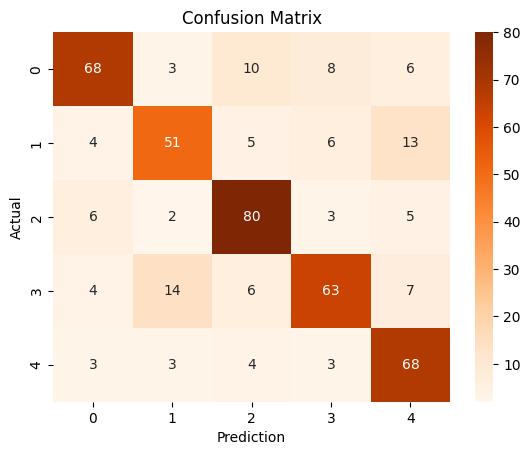

In [26]:
cm = confusion_matrix(validation, prediction)

# print("")
# plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, cmap='Oranges')
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Conclusions

Things to keep in mind
* RNN takes the current input at time <b>t</b> as well as the hidden state from the previous time stamp <b>t-1</b>.
* There are 3 weight Matrices <b>W, U, V</b> from the input, hidden state and output and <b>W, U, V, W', U', V'</b> respectively interms of bi-directional RNN
* BiDirectional RNN process information from left to right and also from riogh
* The same RNN unit is reused for all the input so weights are shared across all time steps.
* The gradients are calculated over time which is called the BPPT.
* Backpropagation through time: what it does and how to do it- https://axon.cs.byu.edu/Dan/678/papers/Recurrent/Werbos.pdf
